In [4]:
#Imports and Settings:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
from datetime import datetime
from datetime import timedelta

#Settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)
%matplotlib inline 
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 40)
pd.set_option('display.width', 1000)

## Codebook / Data Set Information:

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The **target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible.** Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

For students in this course, there was lot of issues about **data leakage** for certain variables, such as "judgement amount", or "late fee". If our goal is to predict unpaid fines once the ticket is issued, these values cannot be used. If our goal is to predict unpaid fines form a batch of data (with information about late fees included for each row), then this isn't Data Leakage. The instructors of the course seem to have chosen the latter interpretation. I go along with this as well.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


## Finding More Features:

Note that we don't have targets for the test set, and due to NA columns in the training set target variable, we already forfeit 30% of the data. 

To evaluate the models, we only have about 60Mb of data to work with. I will split off a test set (10%), and use the remaining data with a default k-fold cross validation (using GridSearchCV). 

I wanted to try out a few more features in our model. They are extracted, below:

#### Let's load the dataset, and remove NAs:

In [5]:
#load the test and training set!

xyTrain = pd.read_csv("./readonly/train.csv",encoding = "ISO-8859-1")
#xyTrain.isnull().sum()

#this came from our isnull() summing; some columns are basically all NA. Useless for us, and I have no data join to correct.
for col in ["violation_zip_code", "non_us_str_code", "payment_date", "collection_status", "grafitti_status"]:
    xyTrain.drop(columns=[col], axis=1,inplace=True)

xyTrain.head(2)

before = xyTrain.shape
xyTrain.dropna(inplace=True)
xyTrain = xyTrain.reset_index(drop=True)
print("Number of rows lost: " + str(before[0] - xyTrain.shape[0]))
print("Rows remaining: " + str(xyTrain.shape[0]))

/home/sean/DSDEenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ticket_id                                     agency_name    inspector_name                      violator_name  violation_street_number violation_street_name  mailing_address_str_number mailing_address_str_name     city state zip_code country   ticket_issued_date         hearing_date violation_code                              violation_description                   disposition  fine_amount  admin_fee  state_fee  late_fee  discount_amount  clean_up_cost  judgment_amount  payment_amount  balance_due      payment_status                         compliance_detail  compliance
0      22056  Buildings, Safety Engineering & Env Department   Sims, Martinzie  INVESTMENT INC., MIDWEST MORTGAGE                   2900.0                 TYLER                         3.0                S. WICKER  CHICAGO    IL    60606     USA  2004-03-16 11:40:00  2005-03-21 10:30:00      9-1-36(a)  Failure of owner to obtain certificate of comp...        Responsible by Default        250.0       20.0       10.0      25.0              0.0            0.0            305.0             0.0        305.0  NO PAYMENT APPLIED               non-compliant by no payment         0.0
1      27586  Buildings, Safety Engineering & Env Department  Williams, Darrin           Michigan, Covenant House                   4311.0               CENTRAL                      2959.0       Martin Luther King  Detroit    MI    48208     USA  2004-04-23 12:30:00  2005-05-06 13:30:00     61-63.0600  Failed To Secure Permit For Lawful Use Of Buil...  Responsible by Determination        750.0       20.0       10.0      75.0              0.0            0.0            855.0           780.0         75.0        PAID IN FULL  compliant by late payment within 1 month         1.0

Number of rows lost: 93307
Rows remaining: 156999


## Features  Selected:

Looking at our codebook (above), I am interested in: 

1) Mapping Strings Categories to Levels, specifically:

    - Violation Code
    
    - Agency Name
    
    - Disposition
    
2) Derived Date Information:
    - (Ticket Issued Date - Hearing Date): with differences measured in units of days.
    
This will give us 7 features in total, in which to experiment with in the Random Forest.


### Exploring our Catagorial Features:


#### Violation Codes:

There are 188 catagories in total. Map to catagory levels. There is one erroneous catagory label ("DO NOT USE"), but this only has one row so it won't matter.

In [14]:
#There are 188 different codes to choose from. 
len(xyTrain['violation_code'].unique().tolist())

#Which codes are the most frequent?
xyTrain.groupby(by="violation_code")["ticket_id"].count()

xyTrain["violation_code"] = xyTrain["violation_code"].astype("category")
xyTrain["violation_code_levels"] = xyTrain["violation_code"].cat.codes
#There are a lot of small catagories here, with most of the features in a few bins.



188

violation_code
19420901                   16
19450901                 1619
19830901                   10
19840901                    2
19850901                    1
20130901                   78
20160901                    1
20180901                   15
22-2-16                    17
22-2-17                  1338
22-2-17(a)                 68
22-2-18                     2
22-2-20                     3
22-2-21(a)                  2
22-2-21(b)                183
22-2-22                  2534
22-2-22(a)                 78
22-2-23                    27
22-2-38                    70
22-2-41                    71
22-2-42                     2
22-2-43                  1996
22-2-44                    48
22-2-45                  4065
22-2-49                     4
22-2-49(b)                  1
22-2-49(c)                  4
22-2-49(d)                  5
22-2-53                    27
22-2-55                     7
22-2-56                    75
22-2-61                   686
22-2-83                  

#### Agency Name:

We see most of the catagories are populated, I ignore the Neighbourhood City Halls catagory.

In [3]:
len(xyTrain['agency_name'].unique().tolist())

#Which codes are the most frequent?
xyTrain.groupby(by="agency_name")["ticket_id"].count()

#I won't impose ordering and just try it as it is.
xyTrain["agency_name"] = xyTrain["agency_name"].astype("category")
xyTrain["agency_codes"] = xyTrain["agency_name"].cat.codes


5

agency_name
Buildings, Safety Engineering & Env Department    95468
Department of Public Works                        50202
Detroit Police Department                          4454
Health Department                                  6874
Neighborhood City Halls                               1
Name: ticket_id, dtype: int64

#### Disposition

Similar to Agency name, we have well populated catagories.

In [4]:
#We do much hte same thing
len(xyTrain['disposition'].unique().tolist())

#Which codes are the most frequent?
xyTrain.groupby(by="disposition")["ticket_id"].count()

xyTrain["disposition"] = xyTrain["disposition"].astype("category")
xyTrain["disposition_codes"] = xyTrain["disposition"].cat.codes


4

disposition
Responsible (Fine Waived) by Deter       186
Responsible by Admission               13434
Responsible by Default                135962
Responsible by Determination            7417
Name: ticket_id, dtype: int64

### Investigating Time Differences: 

To start, we can put the hearing date and ticket date into the model. Do particular seasons have any effects?

A derived feature I wanted to look at was (hearing_date - ticket_date). Is there a standard period in between the two dates, or does it vary? Can we gain some useful information based on the difference in the two time points? My intuition is that long time differences might indicate a problem.

In [22]:
xyTrain["ticket_issued_date"].head(10)
xyTrain["hearing_date"].head(10)

#We need to parse the dates using "%Y-%m-%d %h:%m:%s"

0    2004-03-16 11:40:00
1    2004-04-23 12:30:00
2    2004-05-01 11:50:00
3    2004-06-14 14:15:00
4    2004-06-16 12:30:00
5    2004-06-16 12:25:00
6    2004-07-12 13:30:00
7    2004-07-28 12:15:00
8    2004-08-05 15:00:00
9    2004-08-23 14:15:00
Name: ticket_issued_date, dtype: object

0    2005-03-21 10:30:00
1    2005-05-06 13:30:00
2    2005-03-21 10:30:00
3    2005-02-22 15:00:00
4    2005-02-22 15:00:00
5    2005-02-22 15:00:00
6    2005-05-31 13:30:00
7    2005-02-22 15:00:00
8    2005-02-22 15:00:00
9    2005-02-28 15:00:00
Name: hearing_date, dtype: object

In [8]:
#convert columns to date.
xyTrain["hearing_date"] = pd.to_datetime(arg=xyTrain["hearing_date"], format="%Y-%m-%d %H:%M:%S")
xyTrain["ticket_issued_date"] = pd.to_datetime(arg=xyTrain["ticket_issued_date"], format="%Y-%m-%d %H:%M:%S")

In [9]:
#Lets add a difference column
def getdiffindays(hdate, tdate):
    return ((hdate - tdate).total_seconds())/86400

#Clever solution from: https://stackoverflow.com/questions/13331698/...
#...how-to-apply-a-function-to-two-columns-of-pandas-dataframe
xyTrain['time_diff'] = xyTrain[['hearing_date','ticket_issued_date']].apply(lambda x: getdiffindays(*x), axis=1)


Distribution looks Negative Exponential (in shape), and heavily weighted toward 0 end. Most periods are distributed between 0-400 days.

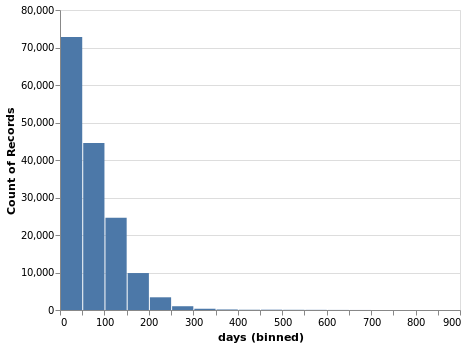

In [10]:
#a histogram would be much better.
#Lets look at the internal core of points (0 - 1000)
timeDF = pd.DataFrame({"days": xyTrain["time_diff"]})
timeDF["catname"] = "timeDelta"

sstimeDF = timeDF[(timeDF["days"] > 0) & (timeDF["days"] < 1000)]
alt.Chart(sstimeDF).mark_bar().encode(
    alt.X("days:Q",  bin=alt.Bin(maxbins=20)),
    y='count()',
)

Some of our time differences are actually negative, which doesn't make sense (can't have a hearing date before ticket date). These items need to be deleted.

In [12]:
(xyTrain["time_diff"] < 0).value_counts()
#might consider getting rid of Negative values; less than 0.1% of data will be lost, doing this.

False    156919
True         80
Name: time_diff, dtype: int64

### Final script to process the data set:

Setup as a functional call. 


In [16]:
#Lets set up our input and target data
#Lets add a difference column
def getdiffindays(hdate, tdate):
    return ((hdate - tdate).total_seconds())/86400

def getfeatures():
    from sklearn.model_selection import train_test_split
    
    xyTrain = pd.read_csv("./readonly/train.csv",encoding = "ISO-8859-1")

    #this came from our isnull() summing; some columns are basically all NA. Useless for us, and I have no data join to correct.
    for col in ["violation_zip_code", "non_us_str_code", "payment_date", "collection_status", "grafitti_status"]:
        xyTrain.drop(columns=[col], axis=1,inplace=True)

    xyTrain.dropna(inplace=True)
    xyTrain = xyTrain.reset_index(drop=True)

    xyTrain["agency_name"] = xyTrain["agency_name"].astype("category")
    xyTrain["agency_codes"] = xyTrain["agency_name"].cat.codes
    xyTrain["disposition"] = xyTrain["disposition"].astype("category")
    xyTrain["disposition_codes"] = xyTrain["disposition"].cat.codes
    xyTrain["violation_code"] = xyTrain["violation_code"].astype("category")
    xyTrain["violation_code_levels"] = xyTrain["violation_code"].cat.codes

    xyTrain["hearing_date"] = pd.to_datetime(arg=xyTrain["hearing_date"], format="%Y-%m-%d %H:%M:%S")
    xyTrain["ticket_issued_date"] = pd.to_datetime(arg=xyTrain["ticket_issued_date"], format="%Y-%m-%d %H:%M:%S")

    xyTrain.astype({"compliance":"int"},inplace=True) #doesn't need to be a float.


    #Clever solution from: https://stackoverflow.com/questions/13331698/...
    #...how-to-apply-a-function-to-two-columns-of-pandas-dataframe
    xyTrain['time_diff'] = xyTrain[['hearing_date','ticket_issued_date']].apply(lambda x: getdiffindays(*x), axis=1)

    #filter out negative times from our dataframe
    xyTrain = xyTrain[xyTrain["time_diff"] > 0]

    #first, split off 10% of xyTrain to get some test data. Set a random seed.
    (xy_Train, xy_Test) = train_test_split(xyTrain,test_size=0.1,random_state=0)
    
    
    y_Train = xy_Train["compliance"]
    x_Train = xy_Train.drop(columns=["compliance","compliance_detail"],axis=1)
    y_Test = xy_Test["compliance"]
    x_Test = xy_Test.drop(columns=["compliance","compliance_detail"],axis=1)
    
    return (x_Train,y_Train,x_Test,y_Test)

In [17]:
(x_Train,y_Train,x_Test,y_Test) = getfeatures()

Taking a quick look at our new dataframes.

In [19]:
x_Train.shape
y_Train.shape
x_Test.shape
y_Test.shape

x_Train.head(2)
x_Test.head(2)

(141226, 31)

(141226,)

(15692, 31)

(15692,)

ticket_id                 agency_name inspector_name                     violator_name  violation_street_number violation_street_name  mailing_address_str_number mailing_address_str_name             city state zip_code country  ticket_issued_date        hearing_date violation_code                              violation_description             disposition  fine_amount  admin_fee  state_fee  late_fee  discount_amount  clean_up_cost  judgment_amount  payment_amount  balance_due      payment_status  agency_codes  disposition_codes  violation_code_levels   time_diff
122611     224987  Department of Public Works  Barela, Ralph  CO  PARTNERSHIP, ROBADON A  MICH                  12040.0                AUBURN                       341.0                 EASTMAIN       NORTHVILLE    MI    48167     USA 2009-07-20 10:00:00 2010-01-07 10:30:00        9-1-104  Excessive weeds or plant growth one- or two-fa...  Responsible by Default        125.0       20.0       10.0      12.5              0.0            0.0            167.5             0.0        167.5  NO PAYMENT APPLIED             1                  2                     94  171.020833
134496     245767  Department of Public Works  Forte, Laurie                GOPEYENKO, ALEKSEY                   9160.0             YORKSHIRE                      6637.0               ANDRION CT  WEST BLOOMFIELD    MI    48322     USA 2010-03-22 10:00:00 2010-06-28 13:30:00     22-2-88(b)  Allowing bulk solid waste to lie or accumulate...  Responsible by Default        200.0       20.0       10.0      20.0              0.0            0.0            250.0           250.0          0.0        PAID IN FULL             1                  2                     46   98.145833

ticket_id                                     agency_name    inspector_name             violator_name  violation_street_number violation_street_name  mailing_address_str_number mailing_address_str_name        city state zip_code country  ticket_issued_date        hearing_date violation_code                              violation_description             disposition  fine_amount  admin_fee  state_fee  late_fee  discount_amount  clean_up_cost  judgment_amount  payment_amount  balance_due      payment_status  agency_codes  disposition_codes  violation_code_levels   time_diff
85584      161497  Buildings, Safety Engineering & Env Department  Steele, Jonathan          PROP. LLC, SMITH                  17141.0             GREENLAWN                       259.0                  WAYWARD  SOUTHFIELD    MI    48076     USA 2008-03-03 10:45:00 2008-04-11 09:00:00      9-1-36(a)  Failure of owner to obtain certificate of comp...  Responsible by Default        250.0       20.0       10.0      25.0              0.0            0.0            305.0             0.0        305.0  NO PAYMENT APPLIED             0                  2                    142   38.927083
125796     229955  Buildings, Safety Engineering & Env Department  Addison, Michael  MUSIC SCHOOL, ART CENTER                   3975.0                  CASS                      3975.0                     CASS     DETROIT    MI    48201     USA 2009-09-04 08:25:00 2010-03-16 10:30:00      9-1-36(a)  Failure of owner to obtain certificate of comp...  Responsible by Default        250.0       20.0       10.0      25.0              0.0            0.0            305.0             0.0        305.0  NO PAYMENT APPLIED             0                  2                    142  193.086806

In [25]:
x_TrainBasic = x_Train.loc[:,["late_fee","discount_amount","judgment_amount","time_diff"]]

In [11]:
x_TrainBasic.head(5)

late_fee  discount_amount  judgment_amount   time_diff  agency_codes  disposition_codes
0      25.0              0.0            305.0  369.951389             0                  2
1      75.0              0.0            855.0  378.041667             0                  3
2      25.0              0.0            305.0  323.944444             0                  2
3      75.0              0.0            855.0  253.031250             0                  2
4      10.0              0.0            140.0  251.104167             0                  2

###  Basic Model Fit:

In [4]:
#Basic Trial with Two models, using accuracy to start. This does NOT mean that AUC will be as good! or comparable!
def allFeaturesModel():
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier

    parameters = {"n_estimators":list(range(1,50)), "max_depth":list(range(1,11)),"n_jobs":[8]} #we don't need max_features as we only have 2 features!

    blightRF = GridSearchCV(RandomForestClassifier(),param_grid=parameters,scoring="accuracy")
    blightRF.fit(x_TrainBasic, y_Train)

    print('Grid best parameter (max. accuracy): ', blightRF.best_params_)
    print('Grid best score (accuracy): ', blightRF.best_score_)

def assignmentModel():
    

/home/sean/DSDEenv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

Grid best parameter (max. accuracy):  {'max_depth': 6, 'n_estimators': 33, 'n_jobs': 8}
Grid best score (accuracy):  0.9427917765966938
